In [44]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [2]:
avi_data = pd.read_excel('Avinash_features_working.xlsx')

In [3]:
avi_data.shape

(273163, 108)

In [4]:
avi_data.columns.to_list()

['matches',
 'match_id',
 'event_name',
 'season',
 'match_type',
 'match_number',
 'match_date',
 'team',
 'batter_id',
 'batter',
 'Batter Batting IR',
 'Batter Bowling IR',
 'bowler',
 'Bowler Batting IR',
 'Bowler Bowling IR',
 'total_runs',
 'total_fours',
 'total_sixes',
 'total_extras',
 'total_balls',
 'total_wickets',
 'wicket_types',
 'players_out',
 'fielders_name',
 'batter_total',
 'balls_faced_by_batter',
 'strike_rate',
 'total_wickets_by_bowler',
 'maiden_overs_by_bowler',
 'batters_faced_in_maiden',
 'faced_maiden_over',
 'total_balls_in_maiden_over',
 'bowlers_faced_by_batter',
 'batters_faced_by_bowler',
 'dot_balls',
 'balls_bowled_by_bowler',
 'total_runs_by_bowler',
 'bowler_econ_rate',
 'batting_points',
 'bowling_points',
 'fielding_points',
 'economy_rate_points',
 'strike_rate_points',
 'Total Points',
 'city',
 'venue',
 'player_of_match',
 'toss_winner',
 'toss_decision',
 'winner',
 'total_runs_till_date',
 'total_runs_in_season_till_date',
 'matches_played

In [5]:
features_col = ['matches', 'match_id', 'event_name', 'season', 'match_type', 'match_number', 'match_date', 'team',
                'batter_id', 'batter', 'Batter Batting IR', 'Batter Bowling IR', 'bowler', 'Bowler Batting IR', 'Bowler Bowling IR',
                'Total Points', 'city', 'venue', 'total_runs_till_date', 'total_runs_in_season_till_date', 'matches_played_till_date',
                'matches_played_in_current_season', 'total_wickets_till_date', 'total_wickets_in_season_till_date',
                'count_player_of_match_in_current_season', 'count_player_of_match_in_all_season', 'avg_strike_rate_last_5',
                'avg_econ_rate_last_5', 'total_runs_till_date_2', 'total_runs_in_season_till_date_2', 'matches_played_till_date_2',
                'matches_played_in_current_season_2', 'total_wickets_till_date_2', 'total_wickets_in_season_till_date_2',
                'avg_strike_rate_last_5_2', 'avg_econ_rate_last_5_2', 'Year', 'known_as', 'Batter_role', 'retained',
                'base_price', 'sold_price', 'season_info', 'match_number_info', 'stage']



In [6]:
data = avi_data[features_col] # Selecting only the features columns

In [8]:
df = data.copy()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273163 entries, 0 to 273162
Data columns (total 45 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   matches                                  273163 non-null  int64         
 1   match_id                                 273163 non-null  int64         
 2   event_name                               273163 non-null  object        
 3   season                                   273163 non-null  int64         
 4   match_type                               273163 non-null  object        
 5   match_number                             256814 non-null  float64       
 6   match_date                               273163 non-null  datetime64[ns]
 7   team                                     273163 non-null  object        
 8   batter_id                                273163 non-null  object        
 9   batter                    

In [11]:
# Calculate the number of null values in each column
null_values = df.isnull().sum()

# Calculate the percentage of null values in each column
null_percentage = (null_values / len(df)) * 100

# Combine the null values and their percentages into a DataFrame
null_summary = pd.DataFrame({'Null Values': null_values, 'Percentage': null_percentage})

print(null_summary)

                                         Null Values  Percentage
matches                                            0    0.000000
match_id                                           0    0.000000
event_name                                         0    0.000000
season                                             0    0.000000
match_type                                         0    0.000000
match_number                                   16349    5.985071
match_date                                         0    0.000000
team                                               0    0.000000
batter_id                                          0    0.000000
batter                                             0    0.000000
Batter Batting IR                             273163  100.000000
Batter Bowling IR                             273163  100.000000
bowler                                             0    0.000000
Bowler Batting IR                             273163  100.000000
Bowler Bowling IR        

## City Imputation

In [12]:
# Create a mapping of unique venues to their corresponding cities
venue_to_city = df.dropna(subset=['city']).drop_duplicates(subset=['venue']).set_index('venue')['city'].to_dict()

# Use the mapping to fill in the missing values in the city column
df['city'] = df.apply(lambda row: venue_to_city[row['venue']] if pd.isnull(row['city']) and row['venue'] in venue_to_city else row['city'], axis=1)

# Verify the changes
print(df['city'].isnull().sum())


0


## Stage Imputation

In [16]:
df.stage.value_counts()

stage
Points Match          256814
Final                   4193
Qualifier 2             3515
Qualifier 1             3467
Eliminator              2754
Semi Final              1452
Elimination Final        726
3rd Place Play-Off       242
Name: count, dtype: int64

In [15]:
df['stage'].fillna('Points Match', inplace=True)

# Verify the changes
print(df['stage'].isnull().sum())

0


## Impute 8 features using KNN


avg_strike_rate_last_5; avg_econ_rate_last_5, avg_strike_rate_last_5_2 avg_econ_rate_last_5_2, Batter_role, retained, base_price, sold_price

In [17]:
# Ensure the correct data types for the columns
df['avg_strike_rate_last_5'] = df['avg_strike_rate_last_5'].astype(float)
df['avg_econ_rate_last_5'] = df['avg_econ_rate_last_5'].astype(float)
df['avg_strike_rate_last_5_2'] = df['avg_strike_rate_last_5_2'].astype(float)
df['avg_econ_rate_last_5_2'] = df['avg_econ_rate_last_5_2'].astype(float)
df['base_price'] = df['base_price'].astype(float)
df['sold_price'] = df['sold_price'].astype(float)
df['Batter_role'] = df['Batter_role'].astype('category')
df['retained'] = df['retained'].astype('category')

In [18]:
# Store the original mappings
batter_role_mapping = dict(enumerate(df['Batter_role'].cat.categories))
retained_mapping = dict(enumerate(df['retained'].cat.categories))

# Convert categorical variables to numeric codes
df['Batter_role'] = df['Batter_role'].cat.codes
df['retained'] = df['retained'].cat.codes

In [19]:
columns_to_impute = [
    'avg_strike_rate_last_5', 'avg_econ_rate_last_5', 
    'avg_strike_rate_last_5_2', 'avg_econ_rate_last_5_2',
    'base_price', 'sold_price', 'Batter_role', 'retained'
]

# Initialize the KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Impute the missing values
df_imputed = df.copy()
df_imputed[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

# Convert the categorical columns back to their original data types
df_imputed['Batter_role'] = df_imputed['Batter_role'].round().astype(int).astype('category')
df_imputed['retained'] = df_imputed['retained'].round().astype(int).astype('category')

In [20]:
# Update the original dataframe with the imputed values
df.update(df_imputed[columns_to_impute])

# Verify the changes
print(df[columns_to_impute].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273163 entries, 0 to 273162
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   avg_strike_rate_last_5    273163 non-null  float64
 1   avg_econ_rate_last_5      273163 non-null  float64
 2   avg_strike_rate_last_5_2  273163 non-null  float64
 3   avg_econ_rate_last_5_2    273163 non-null  float64
 4   base_price                273163 non-null  float64
 5   sold_price                273163 non-null  float64
 6   Batter_role               273163 non-null  int8   
 7   retained                  273163 non-null  int8   
dtypes: float64(6), int8(2)
memory usage: 13.0 MB
None


## Batting International Rating

In [21]:
# Remove all values from the specified columns by setting them to NaN
df[['Batter Batting IR', 'Batter Bowling IR', 'Bowler Batting IR', 'Bowler Bowling IR']] = np.nan

# Verify the changes
print(df[['Batter Batting IR', 'Batter Bowling IR', 'Bowler Batting IR', 'Bowler Bowling IR']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273163 entries, 0 to 273162
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Batter Batting IR  0 non-null      float64
 1   Batter Bowling IR  0 non-null      float64
 2   Bowler Batting IR  0 non-null      float64
 3   Bowler Bowling IR  0 non-null      float64
dtypes: float64(4)
memory usage: 8.3 MB
None


In [22]:
batting_ranking = pd.read_excel('Data from Net/ICC Ranking.xlsx', sheet_name='Batting Ranking')

In [23]:
batting_ranking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1702 entries, 0 to 1701
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month & Year             1702 non-null   datetime64[ns]
 1   Year                     1702 non-null   int64         
 2   Rating                   1702 non-null   object        
 3   Points                   1700 non-null   float64       
 4   Name                     1702 non-null   object        
 5   Avinash Act Name         690 non-null    object        
 6   AUS                      1700 non-null   object        
 7   Career Best T20 Rating   1702 non-null   object        
 8   Career Best T20 Ranking  1702 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 119.8+ KB


### Impute Batter Batting IR

In [24]:
# Create a dictionary for mapping (season, batter) to Rating
batting_ranking_dict = batting_ranking.set_index(['Year', 'Name'])['Rating'].to_dict()

# Impute the Batter Batting IR column
df['Batter Batting IR'] = df.apply(lambda row: batting_ranking_dict.get((row['season'], row['batter']), row['Batter Batting IR']), axis=1)

# Calculate the number of null values in Batter Batting IR column after imputation
null_values_batter_ir = df['Batter Batting IR'].isnull().sum()

# Calculate the percentage of null values in Batter Batting IR column after imputation
null_percentage_batter_ir = (null_values_batter_ir / len(df)) * 100

print(f"Number of null values in 'Batter Batting IR' column after imputation: {null_values_batter_ir}")
print(f"Percentage of null values in 'Batter Batting IR' column after imputation: {null_percentage_batter_ir:.2f}%")

Number of null values in 'Batter Batting IR' column after imputation: 265440
Percentage of null values in 'Batter Batting IR' column after imputation: 97.17%


In [25]:
df['batter'].head()

0    W Jaffer
1     B Akhil
2     B Akhil
3     B Akhil
4     B Akhil
Name: batter, dtype: object

In [26]:
# Create a dictionary for mapping (season, batter) to Rating
batting_ranking_dict = batting_ranking.set_index(['Year', 'Avinash Act Name'])['Rating'].to_dict()

# Impute the Batter Batting IR column
df['Batter Batting IR'] = df.apply(lambda row: batting_ranking_dict.get((row['season'], row['batter']), row['Batter Batting IR']), axis=1)

# Calculate the number of null values in Batter Batting IR column after imputation
null_values_batter_ir = df['Batter Batting IR'].isnull().sum()

# Calculate the percentage of null values in Batter Batting IR column after imputation
null_percentage_batter_ir = (null_values_batter_ir / len(df)) * 100

print(f"Number of null values in 'Batter Batting IR' column after imputation: {null_values_batter_ir}")
print(f"Percentage of null values in 'Batter Batting IR' column after imputation: {null_percentage_batter_ir:.2f}%")

Number of null values in 'Batter Batting IR' column after imputation: 224024
Percentage of null values in 'Batter Batting IR' column after imputation: 82.01%


In [27]:
# Check the top 10 values in 'Batter Batting IR' column
top_10_batter_batting_ir = df['Batter Batting IR'].value_counts().head(10)
print(top_10_batter_batting_ir)

# Check the data type of 'Batter Batting IR' column
batter_batting_ir_dtype = df['Batter Batting IR'].dtype
print(f"Data type of 'Batter Batting IR' column: {batter_batting_ir_dtype}")

Batter Batting IR
8.0     1320
5.0     1243
17.0    1199
32.0    1183
11.0    1166
16.0    1146
1.0     1133
4.0     1045
19.0    1045
7.0     1020
Name: count, dtype: int64
Data type of 'Batter Batting IR' column: float64


### Impute Bowler Batting IR

In [28]:
# Create a dictionary for mapping (season, bowler) to Rating
batting_ranking_dict = batting_ranking.set_index(['Year', 'Name'])['Rating'].to_dict()

# Impute the Bowler Batting IR column
df['Bowler Batting IR'] = df.apply(lambda row: batting_ranking_dict.get((row['season'], row['bowler']), row['Bowler Batting IR']), axis=1)

# Calculate the number of null values in Bowler Batting IR column after imputation
null_values_batter_ir = df['Bowler Batting IR'].isnull().sum()

# Calculate the percentage of null values in Bowler Batting IR column after imputation
null_percentage_batter_ir = (null_values_batter_ir / len(df)) * 100

print(f"Number of null values in 'Bowler Batting IR' column after imputation: {null_values_batter_ir}")
print(f"Percentage of null values in 'Bowler Batting IR' column after imputation: {null_percentage_batter_ir:.2f}%")

Number of null values in 'Bowler Batting IR' column after imputation: 265379
Percentage of null values in 'Bowler Batting IR' column after imputation: 97.15%


In [29]:
# Create a dictionary for mapping (season, bowler) to Rating 
batting_ranking_dict = batting_ranking.set_index(['Year', 'Avinash Act Name'])['Rating'].to_dict()

# Impute the Bowler Batting IR column
df['Bowler Batting IR'] = df.apply(lambda row: batting_ranking_dict.get((row['season'], row['bowler']), row['Bowler Batting IR']), axis=1)

# Calculate the number of null values in Bowler Batting IR column after imputation
null_values_batter_ir = df['Bowler Batting IR'].isnull().sum()

# Calculate the percentage of null values in Bowler Batting IR column after imputation
null_percentage_batter_ir = (null_values_batter_ir / len(df)) * 100

print(f"Number of null values in 'Bowler Batting IR' column after imputation: {null_values_batter_ir}")
print(f"Percentage of null values in 'Bowler Batting IR' column after imputation: {null_percentage_batter_ir:.2f}%")

Number of null values in 'Bowler Batting IR' column after imputation: 223710
Percentage of null values in 'Bowler Batting IR' column after imputation: 81.90%


In [30]:
# Check the top 10 values in 'Bowler Batting IR' column
top_10_batter_batting_ir = df['Bowler Batting IR'].value_counts().head(10)
print(top_10_batter_batting_ir)

# Check the data type of 'Bowler Batting IR' column
batter_batting_ir_dtype = df['Bowler Batting IR'].dtype
print(f"Data type of 'Bowler Batting IR' column: {batter_batting_ir_dtype}")

Bowler Batting IR
8.0     1332
5.0     1249
17.0    1214
32.0    1189
11.0    1172
16.0    1151
1.0     1143
19.0    1057
4.0     1056
7.0     1029
Name: count, dtype: int64
Data type of 'Bowler Batting IR' column: float64


## Bowling International Rating

In [31]:
df['bowler'].tail()

273158            B Kumar
273159    Abhishek Sharma
273160        Abdul Samad
273161            TM Head
273162        T Natarajan
Name: bowler, dtype: object

In [32]:
bowling_ranking = pd.read_excel('Data from Net/ICC Ranking.xlsx', sheet_name='Bowling Ranking')

In [33]:
bowling_ranking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month & Year             1700 non-null   datetime64[ns]
 1   Year                     1700 non-null   int64         
 2   Rating                   1700 non-null   int64         
 3   Points                   1700 non-null   int64         
 4   Name                     1700 non-null   object        
 5   Avinash Act Names        715 non-null    object        
 6   Country                  1700 non-null   object        
 7   Career Best T20 Rating   1700 non-null   object        
 8   Career Best T20 Ranking  1700 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 119.7+ KB


### Impute Batter Bowling IR

In [34]:
# Create a dictionary for mapping (season, batter) to Rating
bowling_ranking_dict = bowling_ranking.set_index(['Year', 'Name'])['Rating'].to_dict()

# Impute the Batter Bowling IR column
df['Batter Bowling IR'] = df.apply(lambda row: bowling_ranking_dict.get((row['season'], row['batter']), row['Batter Bowling IR']), axis=1)

# Calculate the number of null values in Batter Bowling IR column after imputation
null_values_batter_ir = df['Batter Bowling IR'].isnull().sum()

# Calculate the percentage of null values in Batter Bowling IR column after imputation
null_percentage_batter_ir = (null_values_batter_ir / len(df)) * 100

print(f"Number of null values in 'Batter Bowling IR' column after imputation: {null_values_batter_ir}")
print(f"Percentage of null values in 'Batter Bowling IR' column after imputation: {null_percentage_batter_ir:.2f}%")

Number of null values in 'Batter Bowling IR' column after imputation: 263353
Percentage of null values in 'Batter Bowling IR' column after imputation: 96.41%


In [35]:
# Create a dictionary for mapping (season, batter) to Rating
bowling_ranking_dict = bowling_ranking.set_index(['Year', 'Avinash Act Names'])['Rating'].to_dict()

# Impute the Batter Bowling IR column
df['Batter Bowling IR'] = df.apply(lambda row: bowling_ranking_dict.get((row['season'], row['batter']), row['Batter Bowling IR']), axis=1)

# Calculate the number of null values in Batter Bowling IR column after imputation
null_values_batter_ir = df['Batter Bowling IR'].isnull().sum()

# Calculate the percentage of null values in Batter Bowling IR column after imputation
null_percentage_batter_ir = (null_values_batter_ir / len(df)) * 100

print(f"Number of null values in 'Batter Bowling IR' column after imputation: {null_values_batter_ir}")
print(f"Percentage of null values in 'Batter Bowling IR' column after imputation: {null_percentage_batter_ir:.2f}%")

Number of null values in 'Batter Bowling IR' column after imputation: 226693
Percentage of null values in 'Batter Bowling IR' column after imputation: 82.99%


In [36]:
# Check the top 10 values in 'Batter Bowling IR' column
top_10_batter_batting_ir = df['Batter Bowling IR'].value_counts().head(10)
print(top_10_batter_batting_ir)

# Check the data type of 'Batter Bowling IR' column
batter_batting_ir_dtype = df['Batter Bowling IR'].dtype
print(f"Data type of 'Batter Bowling IR' column: {batter_batting_ir_dtype}")

Batter Bowling IR
1.0     1338
14.0    1112
20.0    1013
2.0     1012
12.0    1001
43.0     974
8.0      891
4.0      816
44.0     815
26.0     781
Name: count, dtype: int64
Data type of 'Batter Bowling IR' column: float64


In [37]:
df['Batter Bowling IR'].value_counts()

Batter Bowling IR
1.0     1338
14.0    1112
20.0    1013
2.0     1012
12.0    1001
        ... 
96.0     110
75.0      99
67.0      88
87.0      55
27.0      11
Name: count, Length: 97, dtype: int64

### Impute Bowler Bowling IR

In [38]:
# Create a dictionary for mapping (season, batter) to Rating
bowling_ranking_dict = bowling_ranking.set_index(['Year', 'Name'])['Rating'].to_dict()

# Impute the Bowler Bowling IR column
df['Bowler Bowling IR'] = df.apply(lambda row: bowling_ranking_dict.get((row['season'], row['bowler']), row['Bowler Bowling IR']), axis=1)

# Calculate the number of null values in Bowler Bowling IR column after imputation
null_values_batter_ir = df['Bowler Bowling IR'].isnull().sum()

# Calculate the percentage of null values in Bowler Bowling IR column after imputation
null_percentage_batter_ir = (null_values_batter_ir / len(df)) * 100

print(f"Number of null values in 'Bowler Bowling IR' column after imputation: {null_values_batter_ir}")
print(f"Percentage of null values in 'Bowler Bowling IR' column after imputation: {null_percentage_batter_ir:.2f}%")

Number of null values in 'Bowler Bowling IR' column after imputation: 263275
Percentage of null values in 'Bowler Bowling IR' column after imputation: 96.38%


In [39]:
# Create a dictionary for mapping (season, batter) to Rating
bowling_ranking_dict = bowling_ranking.set_index(['Year', 'Avinash Act Names'])['Rating'].to_dict()

# Impute the Bowler Bowling IR column
df['Bowler Bowling IR'] = df.apply(lambda row: bowling_ranking_dict.get((row['season'], row['bowler']), row['Bowler Bowling IR']), axis=1)

# Calculate the number of null values in Bowler Bowling IR column after imputation
null_values_batter_ir = df['Bowler Bowling IR'].isnull().sum()

# Calculate the percentage of null values in Bowler Bowling IR column after imputation
null_percentage_batter_ir = (null_values_batter_ir / len(df)) * 100

print(f"Number of null values in 'Bowler Bowling IR' column after imputation: {null_values_batter_ir}")
print(f"Percentage of null values in 'Bowler Bowling IR' column after imputation: {null_percentage_batter_ir:.2f}%")

Number of null values in 'Bowler Bowling IR' column after imputation: 226475
Percentage of null values in 'Bowler Bowling IR' column after imputation: 82.91%


In [40]:
# Check the top 10 values in 'Bowler Bowling IR' column
top_10_batter_batting_ir = df['Bowler Bowling IR'].value_counts().head(10)
print(top_10_batter_batting_ir)

# Check the data type of 'Bowler Bowling IR' column
batter_batting_ir_dtype = df['Bowler Bowling IR'].dtype
print(f"Data type of 'Bowler Bowling IR' column: {batter_batting_ir_dtype}")

Bowler Bowling IR
1.0     1347
14.0    1117
2.0     1029
20.0    1020
12.0    1011
43.0     976
8.0      897
4.0      822
44.0     818
11.0     789
Name: count, dtype: int64
Data type of 'Bowler Bowling IR' column: float64


# Imputer Null Ranking Cells

In [41]:
df['Batter Batting IR'] = df['Batter Batting IR'].fillna(120)
df['Batter Bowling IR'] = df['Batter Bowling IR'].fillna(120)
df['Bowler Batting IR'] = df['Bowler Batting IR'].fillna(120)
df['Bowler Bowling IR'] = df['Bowler Bowling IR'].fillna(120)

# Verify the changes
print(df[['Batter Batting IR', 'Batter Bowling IR', 'Bowler Batting IR', 'Bowler Bowling IR']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273163 entries, 0 to 273162
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Batter Batting IR  273163 non-null  float64
 1   Batter Bowling IR  273163 non-null  float64
 2   Bowler Batting IR  273163 non-null  float64
 3   Bowler Bowling IR  273163 non-null  float64
dtypes: float64(4)
memory usage: 8.3 MB
None


In [42]:
df['bowler'].tail(20)

273143        Ramandeep Singh
273144     Rahmanullah Gurbaz
273145               RK Singh
273146               MA Starc
273147           Harshit Rana
273148               CV Varun
273149                TM Head
273150             AD Russell
273151            T Natarajan
273152          Shahbaz Ahmed
273153            RA Tripathi
273154             PJ Cummins
273155    Nithish Kumar Reddy
273156             JD Unadkat
273157              H Klaasen
273158                B Kumar
273159        Abhishek Sharma
273160            Abdul Samad
273161                TM Head
273162            T Natarajan
Name: bowler, dtype: object

## Corr & Sig Tests

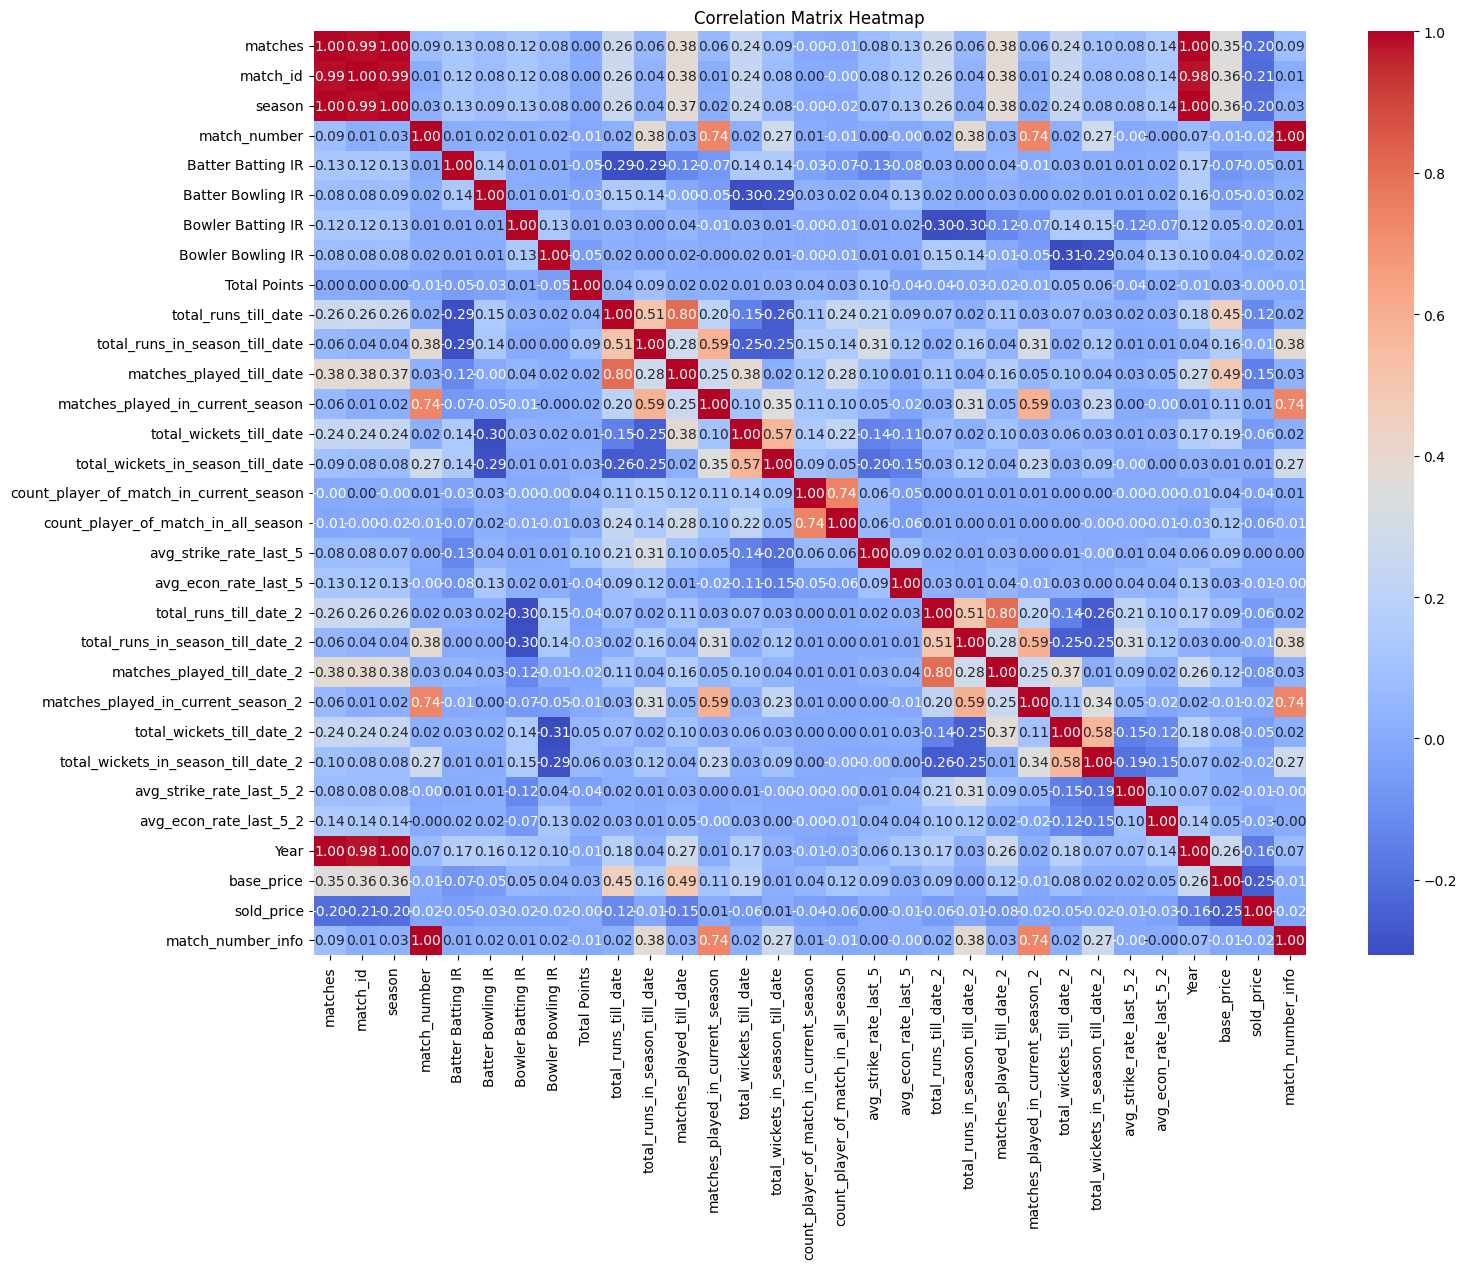

In [46]:
# Select only the integer and float type columns
int_float_columns = df.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix
correlation_matrix = int_float_columns.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [47]:
# List of categorical columns to test
categorical_columns = ['team', 'batter', 'bowler', 'city', 'venue', 'Batter_role', 'retained', 'stage']

# Dictionary to store the results
chi2_results = {}

# Perform chi-square test for each categorical column
for col in categorical_columns:
    contingency_table = pd.crosstab(df[col], df['Total Points'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    chi2_results[col] = p

# Convert the results to a DataFrame for better visualization
chi2_results_df = pd.DataFrame(list(chi2_results.items()), columns=['Feature', 'p-value'])

print(chi2_results_df)

       Feature        p-value
0         team   6.140952e-76
1       batter   1.000000e+00
2       bowler   0.000000e+00
3         city   1.254622e-05
4        venue  4.454743e-256
5  Batter_role   0.000000e+00
6     retained   1.056055e-14
7        stage   1.000000e+00


In [48]:
columns_to_drop = ['matches', 'match_id', 'event_name', 'match_type', 'match_number','matches_played_till_date', 'matches_played_till_date_2',
                    'match_date', 'batter_id', 'Year', 'known_as', 'season_info', 'match_number_info']

df = df.drop(columns=columns_to_drop)

## Team Names

In [49]:
sorted_unique_teams = sorted(df['team'].unique().tolist())
print(sorted_unique_teams)

['Chennai Super Kings', 'Deccan Chargers', 'Delhi Capitals', 'Delhi Daredevils', 'Gujarat Lions', 'Gujarat Titans', 'Kings XI Punjab', 'Kochi Tuskers Kerala', 'Kolkata Knight Riders', 'Lucknow Super Giants', 'Mumbai Indians', 'Pune Warriors', 'Punjab Kings', 'Rajasthan Royals', 'Rising Pune Supergiant', 'Rising Pune Supergiants', 'Royal Challengers Bangalore', 'Royal Challengers Bengaluru', 'Sunrisers Hyderabad']


In [50]:
# Define the replacements
replacements = {
    'Deccan Chargers': 'Sunrisers Hyderabad',
    'Delhi Daredevils': 'Delhi Capitals',
    'Gujarat Lions': 'Gujarat Titans',
    'Kings XI Punjab': 'Punjab Kings',
    'Rising Pune Supergiant': 'Rising Pune Supergiants',
    'Royal Challengers Bangalore': 'Royal Challengers Bengaluru'
}

# Replace the team names in the 'team' column
df['team'] = df['team'].replace(replacements)

## Venues

In [55]:
sorted(df['venue'].unique())

['Arun Jaitley Stadium',
 'Barabati Stadium',
 'Barsapara Cricket Stadium, Guwahati',
 'Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow',
 'Brabourne Stadium',
 'Buffalo Park',
 'De Beers Diamond Oval',
 'Dr DY Patil Sports Academy',
 'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',
 'Dubai International Cricket Stadium',
 'Eden Gardens',
 'Feroz Shah Kotla',
 'Green Park',
 'Himachal Pradesh Cricket Association Stadium',
 'Holkar Cricket Stadium',
 'JSCA International Stadium Complex',
 'Kingsmead',
 'M Chinnaswamy Stadium',
 'MA Chidambaram Stadium',
 'Maharaja Yadavindra Singh International Cricket Stadium, Mullanpur',
 'Maharashtra Cricket Association Stadium',
 'Narendra Modi Stadium, Ahmedabad',
 'Nehru Stadium',
 'New Wanderers Stadium',
 'Newlands',
 'OUTsurance Oval',
 'Punjab Cricket Association IS Bindra Stadium',
 'Rajiv Gandhi International Stadium',
 'Sardar Patel Stadium, Motera',
 'Saurashtra Cricket Association Stadium',
 'Sawai Mansingh Sta

In [54]:
venue_replacements = {
    'Arun Jaitley Stadium, Delhi': 'Arun Jaitley Stadium',
    'Brabourne Stadium, Mumbai': 'Brabourne Stadium',
    'Dr DY Patil Sports Academy, Mumbai': 'Dr DY Patil Sports Academy',
    'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam': 'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',
    'Eden Gardens, Kolkata': 'Eden Gardens',
    'Himachal Pradesh Cricket Association Stadium, Dharamsala': 'Himachal Pradesh Cricket Association Stadium',
    'M Chinnaswamy Stadium, Bengaluru': 'M Chinnaswamy Stadium',
    'M.Chinnaswamy Stadium': 'M Chinnaswamy Stadium',
    'MA Chidambaram Stadium, Chepauk': 'MA Chidambaram Stadium',
    'MA Chidambaram Stadium, Chepauk, Chennai': 'MA Chidambaram Stadium',
    'Maharashtra Cricket Association Stadium, Pune': 'Maharashtra Cricket Association Stadium',
    'Punjab Cricket Association IS Bindra Stadium, Mohali': 'Punjab Cricket Association IS Bindra Stadium',
    'Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh': 'Punjab Cricket Association IS Bindra Stadium',
    'Punjab Cricket Association Stadium, Mohali': 'Punjab Cricket Association IS Bindra Stadium',
    'Rajiv Gandhi International Stadium, Uppal': 'Rajiv Gandhi International Stadium',
    'Rajiv Gandhi International Stadium, Uppal, Hyderabad': 'Rajiv Gandhi International Stadium',
    'Sawai Mansingh Stadium, Jaipur': 'Sawai Mansingh Stadium',
    'Wankhede Stadium, Mumbai': 'Wankhede Stadium'
}

df['venue'] = df['venue'].replace(venue_replacements)

In [56]:
df['batter'].tail(20)

273143       TM Head
273144       TM Head
273145       TM Head
273146       TM Head
273147       TM Head
273148       TM Head
273149    AD Russell
273150       TM Head
273151      MA Starc
273152      MA Starc
273153      MA Starc
273154      MA Starc
273155      MA Starc
273156      MA Starc
273157      MA Starc
273158      MA Starc
273159      MA Starc
273160      MA Starc
273161      MA Starc
273162      VG Arora
Name: batter, dtype: object

# Saving data

In [57]:
df.to_excel('Model_Data.xlsx', index=False)

print('Data saved for model')

Data saved for model
